# 25g: Partner Synergy

**Goal**: Do partner hand features modify the value of your own hand?

**Key Question**: Is having doubles worth more when your partner also has doubles?

**Method**:
1. Extract features for P0 (declarer) and P2 (partner)
2. Run interaction regression: `E[V] ~ p0_doubles + p2_doubles + p0_doubles:p2_doubles`
3. Test significance of interaction term

**Expected Output**: "P0 doubles worth +X when partner also has doubles vs +Y otherwise"

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"
DATA_DIR = "/mnt/d/shards-standard/train"
N_SEEDS = 200  # Use full 200-seed sample

import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import gc

from forge.analysis.utils import viz, loading
from forge.oracle import schema
from forge.oracle.rng import deal_from_seed

viz.setup_notebook_style()
np.random.seed(42)
print("Ready")

Ready


## 1. Extract P0 and P2 Hand Features

In [2]:
def count_doubles(hand: list) -> int:
    """Count doubles in a hand."""
    return sum(1 for d in hand if schema.domino_pips(d)[0] == schema.domino_pips(d)[1])

def get_trump_count(hand: list, trump_suit: int) -> int:
    """Count trumps in hand."""
    if trump_suit is None or trump_suit == 7:  # No trump
        return 0
    return sum(1 for d in hand if trump_suit in schema.domino_pips(d))

def has_trump_double(hand: list, trump_suit: int) -> bool:
    """Check if hand has the trump double."""
    if trump_suit is None or trump_suit == 7:
        return False
    for d in hand:
        pips = schema.domino_pips(d)
        if pips[0] == pips[1] == trump_suit:
            return True
    return False

print("Feature extraction functions defined")

Feature extraction functions defined


In [3]:
# Load features from the unified feature file (12b)
# This has P0 features only - we need to add P2 features

unified_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/12b_unified_features.csv"
df_base = pd.read_csv(unified_path)
print(f"Loaded {len(df_base)} seeds from unified features")
print(f"Columns: {df_base.columns.tolist()}")

Loaded 200 seeds from unified features
Columns: ['base_seed', 'decl_id', 'trump_suit', 'V_mean', 'V_std', 'V_spread', 'V_min', 'V_max', 'n_doubles', 'trump_count', 'max_suit_length', 'n_6_high', 'n_5_high', 'n_4_high', 'count_points', 'n_count_dominoes', 'total_pips', 'has_trump_double', 'n_voids', 'n_singletons']


In [4]:
# Extract P2 features for each seed
p2_features = []

for idx, row in df_base.iterrows():
    seed = int(row['base_seed'])
    decl_id = int(row['decl_id'])
    
    # Deal cards
    hands = deal_from_seed(seed)
    
    # P0 is declarer, P2 is partner
    p0_hand = hands[0]
    p2_hand = hands[2]  # Partner
    
    # Trump suit from decl_id (0-6 = trump, 7+ = no-trump)
    trump_suit = decl_id if decl_id < 7 else None
    
    p2_features.append({
        'base_seed': seed,
        'p2_doubles': count_doubles(p2_hand),
        'p2_trump_count': get_trump_count(p2_hand, trump_suit),
        'p2_has_trump_double': int(has_trump_double(p2_hand, trump_suit)),
    })

p2_df = pd.DataFrame(p2_features)
print(f"Extracted P2 features for {len(p2_df)} seeds")
print(f"P2 doubles distribution: {p2_df['p2_doubles'].value_counts().sort_index().to_dict()}")

Extracted P2 features for 200 seeds
P2 doubles distribution: {0: 18, 1: 69, 2: 67, 3: 37, 4: 8, 5: 1}


In [5]:
# Merge P0 and P2 features
df = df_base.merge(p2_df, on='base_seed')

# Rename P0 features for clarity (original column names from 12b)
df = df.rename(columns={
    'n_doubles': 'p0_doubles',
    'trump_count': 'p0_trump_count',
    'has_trump_double': 'p0_has_trump_double',
    'V_mean': 'ev_mean',
    'V_std': 'ev_std'
})

print(f"Combined dataset: {len(df)} seeds")
print(f"\nP0 doubles: mean={df['p0_doubles'].mean():.2f}, std={df['p0_doubles'].std():.2f}")
print(f"P2 doubles: mean={df['p2_doubles'].mean():.2f}, std={df['p2_doubles'].std():.2f}")

Combined dataset: 200 seeds

P0 doubles: mean=1.73, std=0.98
P2 doubles: mean=1.75, std=1.02


## 2. Interaction Regression Analysis

In [6]:
# Main effects only model
model_main = ols('ev_mean ~ p0_doubles + p2_doubles', data=df).fit()

print("MODEL 1: Main Effects Only")
print("="*50)
print(model_main.summary().tables[1])
print(f"\nR² = {model_main.rsquared:.4f}")

MODEL 1: Main Effects Only
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4423      3.320      0.133      0.894      -6.106       6.990
p0_doubles     6.9580      1.156      6.020      0.000       4.679       9.238
p2_doubles     0.7979      1.106      0.722      0.471      -1.383       2.979

R² = 0.1585


In [7]:
# Interaction model
model_interaction = ols('ev_mean ~ p0_doubles * p2_doubles', data=df).fit()

print("MODEL 2: With Interaction Term")
print("="*50)
print(model_interaction.summary().tables[1])
print(f"\nR² = {model_interaction.rsquared:.4f}")

MODEL 2: With Interaction Term
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -1.3164      4.716     -0.279      0.780     -10.616       7.984
p0_doubles                7.9730      2.250      3.544      0.000       3.536      12.410
p2_doubles                1.7310      2.091      0.828      0.409      -2.393       5.855
p0_doubles:p2_doubles    -0.5902      1.122     -0.526      0.599      -2.802       1.622

R² = 0.1597


In [8]:
# ANOVA comparison: Does interaction improve fit?
from scipy.stats import f as f_dist

# F-test for nested models
rss_main = model_main.ssr
rss_int = model_interaction.ssr
df_diff = model_main.df_resid - model_interaction.df_resid  # Usually 1
df_int = model_interaction.df_resid

f_stat = ((rss_main - rss_int) / df_diff) / (rss_int / df_int)
p_interaction = 1 - f_dist.cdf(f_stat, df_diff, df_int)

print("ANOVA: Main Effects vs Interaction Model")
print("="*50)
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_interaction:.4f}")
print(f"R² improvement: {model_interaction.rsquared - model_main.rsquared:.4f}")

if p_interaction < 0.05:
    print("\n→ Interaction term is SIGNIFICANT (p < 0.05)")
else:
    print("\n→ Interaction term is NOT significant (p >= 0.05)")

ANOVA: Main Effects vs Interaction Model
F-statistic: 0.2768
p-value: 0.5994
R² improvement: 0.0012

→ Interaction term is NOT significant (p >= 0.05)


In [9]:
# Extract key coefficients
coef_p0 = model_interaction.params['p0_doubles']
coef_p2 = model_interaction.params['p2_doubles']
coef_int = model_interaction.params['p0_doubles:p2_doubles']

ci_p0 = model_interaction.conf_int().loc['p0_doubles']
ci_p2 = model_interaction.conf_int().loc['p2_doubles']
ci_int = model_interaction.conf_int().loc['p0_doubles:p2_doubles']

print("\nCOEFFICIENTS WITH 95% CI:")
print("="*50)
print(f"P0 doubles:      {coef_p0:+.2f} [{ci_p0[0]:+.2f}, {ci_p0[1]:+.2f}]")
print(f"P2 doubles:      {coef_p2:+.2f} [{ci_p2[0]:+.2f}, {ci_p2[1]:+.2f}]")
print(f"P0×P2 interact:  {coef_int:+.2f} [{ci_int[0]:+.2f}, {ci_int[1]:+.2f}]")


COEFFICIENTS WITH 95% CI:
P0 doubles:      +7.97 [+3.54, +12.41]
P2 doubles:      +1.73 [-2.39, +5.85]
P0×P2 interact:  -0.59 [-2.80, +1.62]


## 3. Trump Count Interaction

In [10]:
# Also test trump count interaction
model_trump = ols('ev_mean ~ p0_trump_count * p2_trump_count', data=df).fit()

print("MODEL 3: Trump Count Interaction")
print("="*50)
print(model_trump.summary().tables[1])
print(f"\nR² = {model_trump.rsquared:.4f}")

MODEL 3: Trump Count Interaction
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        13.2373      1.923      6.885      0.000       9.445      17.029
p0_trump_count                    0.6939      1.406      0.493      0.622      -2.080       3.467
p2_trump_count                   -4.7986      1.400     -3.428      0.001      -7.559      -2.038
p0_trump_count:p2_trump_count     2.8016      1.045      2.681      0.008       0.741       4.862

R² = 0.1071


In [11]:
# Full model with both doubles and trump
model_full = ols('ev_mean ~ p0_doubles + p2_doubles + p0_trump_count + p2_trump_count + '
                 'p0_doubles:p2_doubles + p0_trump_count:p2_trump_count', data=df).fit()

print("MODEL 4: Full Model (Doubles + Trump + Interactions)")
print("="*50)
print(model_full.summary().tables[1])
print(f"\nR² = {model_full.rsquared:.4f}")

MODEL 4: Full Model (Doubles + Trump + Interactions)
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -3.9323      4.587     -0.857      0.392     -12.979       5.115
p0_doubles                        9.0573      2.100      4.314      0.000       4.916      13.199
p2_doubles                        2.0051      1.957      1.025      0.307      -1.854       5.864
p0_trump_count                    1.8219      1.290      1.412      0.160      -0.723       4.367
p2_trump_count                   -4.6948      1.270     -3.696      0.000      -7.200      -2.189
p0_doubles:p2_doubles            -1.0264      1.049     -0.978      0.329      -3.096       1.043
p0_trump_count:p2_trump_count     2.3798      0.951      2.503      0.013       0.504       4.255

R² = 0.2857


## 4. Visualization

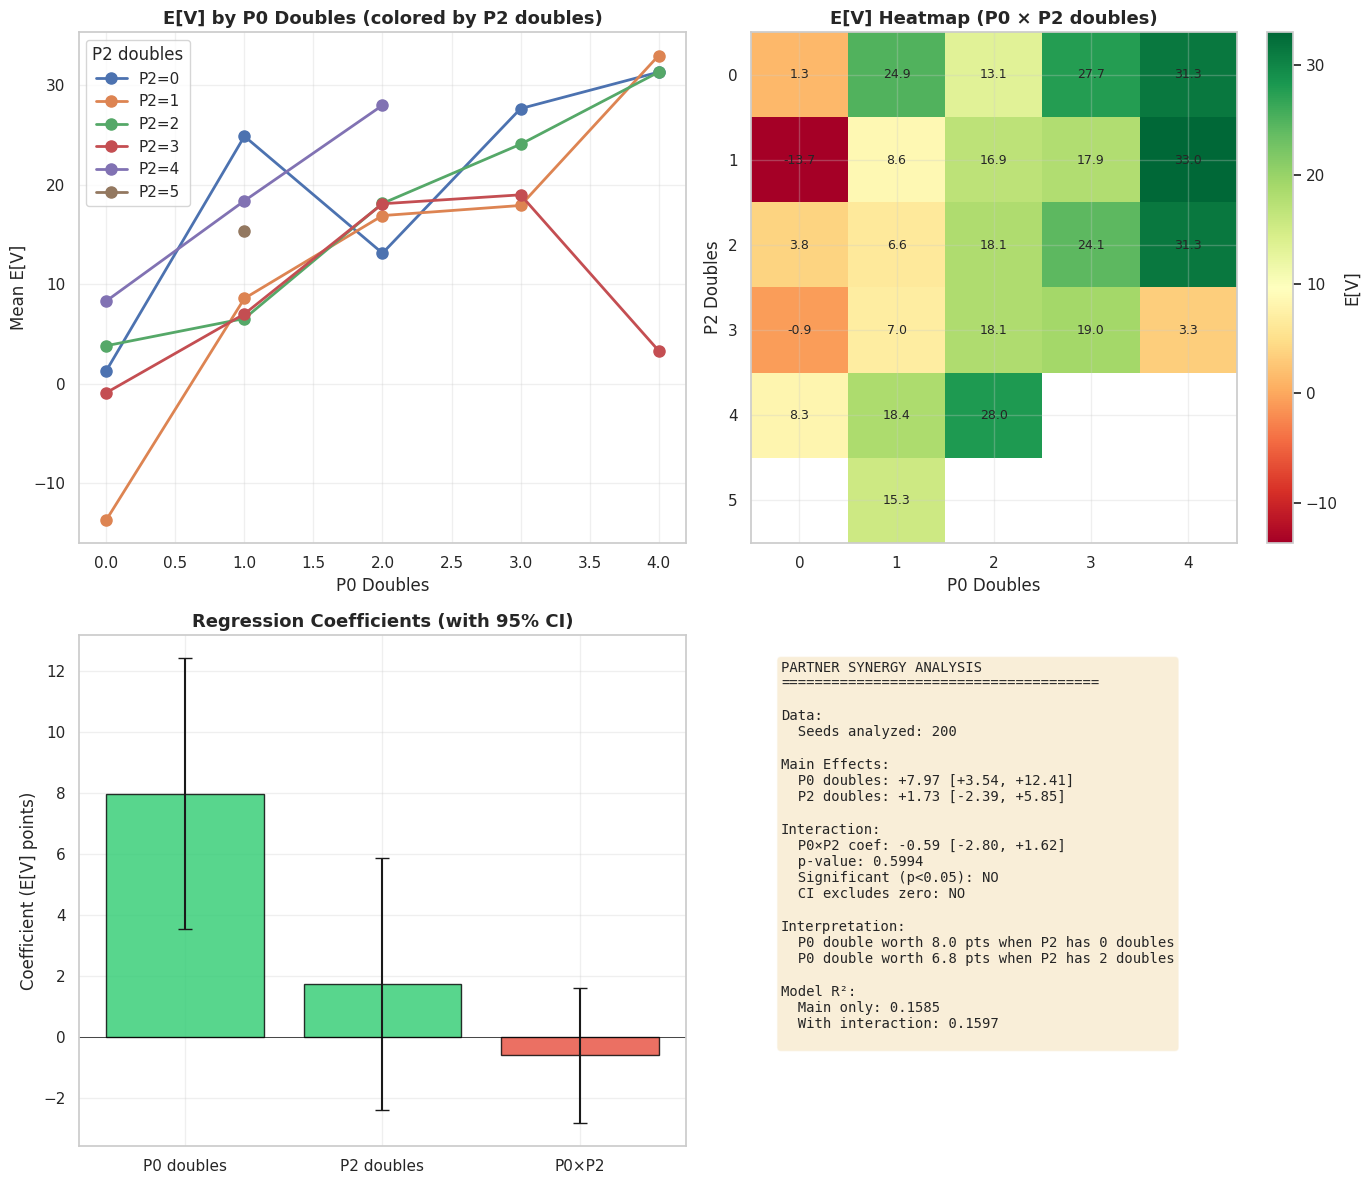

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: E[V] by P0 doubles, colored by P2 doubles
ax = axes[0, 0]
for p2_val in sorted(df['p2_doubles'].unique()):
    subset = df[df['p2_doubles'] == p2_val]
    means = subset.groupby('p0_doubles')['ev_mean'].mean()
    ax.plot(means.index, means.values, 'o-', label=f'P2={p2_val}', markersize=8, linewidth=2)
ax.set_xlabel('P0 Doubles', fontsize=12)
ax.set_ylabel('Mean E[V]', fontsize=12)
ax.set_title('E[V] by P0 Doubles (colored by P2 doubles)', fontsize=13, fontweight='bold')
ax.legend(title='P2 doubles')
ax.grid(True, alpha=0.3)

# Plot 2: Interaction heatmap
ax = axes[0, 1]
pivot = df.pivot_table(values='ev_mean', index='p2_doubles', columns='p0_doubles', aggfunc='mean')
im = ax.imshow(pivot, cmap='RdYlGn', aspect='auto')
ax.set_xticks(range(len(pivot.columns)))
ax.set_xticklabels(pivot.columns)
ax.set_yticks(range(len(pivot.index)))
ax.set_yticklabels(pivot.index)
ax.set_xlabel('P0 Doubles', fontsize=12)
ax.set_ylabel('P2 Doubles', fontsize=12)
ax.set_title('E[V] Heatmap (P0 × P2 doubles)', fontsize=13, fontweight='bold')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('E[V]')

# Add values to heatmap
for i in range(len(pivot.index)):
    for j in range(len(pivot.columns)):
        val = pivot.iloc[i, j]
        if not np.isnan(val):
            ax.text(j, i, f'{val:.1f}', ha='center', va='center', fontsize=9)

# Plot 3: Coefficient comparison
ax = axes[1, 0]
coefs = ['P0 doubles', 'P2 doubles', 'P0×P2']
values = [coef_p0, coef_p2, coef_int]
errors = [(ci_p0[1]-ci_p0[0])/2, (ci_p2[1]-ci_p2[0])/2, (ci_int[1]-ci_int[0])/2]

colors = ['#2ecc71' if v > 0 else '#e74c3c' for v in values]
bars = ax.bar(coefs, values, yerr=errors, capsize=5, color=colors, alpha=0.8, edgecolor='black')
ax.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax.set_ylabel('Coefficient (E[V] points)', fontsize=12)
ax.set_title('Regression Coefficients (with 95% CI)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Summary
ax = axes[1, 1]
ax.axis('off')

# Calculate practical interpretation
# Effect of P0 double when P2 has 0 vs 2 doubles
effect_p0_when_p2_0 = coef_p0
effect_p0_when_p2_2 = coef_p0 + 2 * coef_int

interaction_significant = 'YES' if p_interaction < 0.05 else 'NO'
interaction_ci_excludes_zero = 'YES' if (ci_int[0] > 0 or ci_int[1] < 0) else 'NO'

summary_text = f"""PARTNER SYNERGY ANALYSIS
======================================

Data:
  Seeds analyzed: {len(df)}
  
Main Effects:
  P0 doubles: {coef_p0:+.2f} [{ci_p0[0]:+.2f}, {ci_p0[1]:+.2f}]
  P2 doubles: {coef_p2:+.2f} [{ci_p2[0]:+.2f}, {ci_p2[1]:+.2f}]

Interaction:
  P0×P2 coef: {coef_int:+.2f} [{ci_int[0]:+.2f}, {ci_int[1]:+.2f}]
  p-value: {p_interaction:.4f}
  Significant (p<0.05): {interaction_significant}
  CI excludes zero: {interaction_ci_excludes_zero}

Interpretation:
  P0 double worth {effect_p0_when_p2_0:.1f} pts when P2 has 0 doubles
  P0 double worth {effect_p0_when_p2_2:.1f} pts when P2 has 2 doubles

Model R²:
  Main only: {model_main.rsquared:.4f}
  With interaction: {model_interaction.rsquared:.4f}
"""

ax.text(0.05, 0.95, summary_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('../../results/figures/25g_partner_synergy.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Save Results

In [13]:
# Create results DataFrame
results = {
    'metric': [
        'n_seeds', 
        'coef_p0_doubles', 'ci_p0_low', 'ci_p0_high', 'p_p0',
        'coef_p2_doubles', 'ci_p2_low', 'ci_p2_high', 'p_p2',
        'coef_interaction', 'ci_int_low', 'ci_int_high', 'p_interaction',
        'r2_main_only', 'r2_with_interaction', 'r2_improvement',
        'interaction_significant', 'interaction_ci_excludes_zero'
    ],
    'value': [
        len(df),
        coef_p0, ci_p0[0], ci_p0[1], model_interaction.pvalues['p0_doubles'],
        coef_p2, ci_p2[0], ci_p2[1], model_interaction.pvalues['p2_doubles'],
        coef_int, ci_int[0], ci_int[1], p_interaction,
        model_main.rsquared, model_interaction.rsquared, 
        model_interaction.rsquared - model_main.rsquared,
        int(p_interaction < 0.05), int(ci_int[0] > 0 or ci_int[1] < 0)
    ]
}
results_df = pd.DataFrame(results)

# Save
output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/25g_partner_synergy.csv"
results_df.to_csv(output_path, index=False)
print(f"Saved to {output_path}")

Saved to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/25g_partner_synergy.csv


## Key Findings

In [14]:
print("\n" + "="*60)
print("KEY INSIGHTS: Partner Synergy Analysis")
print("="*60)

print(f"\n1. QUESTION:")
print("   Is having doubles worth more when your partner also has doubles?")

print(f"\n2. DATA:")
print(f"   Seeds analyzed: {len(df)}")

print(f"\n3. MAIN EFFECTS:")
print(f"   P0 doubles: {coef_p0:+.2f} E[V] per double")
print(f"   P2 doubles: {coef_p2:+.2f} E[V] per double")

print(f"\n4. INTERACTION EFFECT:")
print(f"   P0×P2: {coef_int:+.2f} [{ci_int[0]:+.2f}, {ci_int[1]:+.2f}]")
print(f"   p-value: {p_interaction:.4f}")

if p_interaction < 0.05:
    print(f"\n5. CONFIRMED: Partner synergy exists!")
    print(f"   P0 double worth {effect_p0_when_p2_0:.1f} pts when P2 has 0 doubles")
    print(f"   P0 double worth {effect_p0_when_p2_2:.1f} pts when P2 has 2 doubles")
else:
    print(f"\n5. NOT CONFIRMED: No significant partner synergy")
    print(f"   Doubles effect is additive (no interaction)")
    print(f"   Your doubles are worth the same regardless of partner's hand")


KEY INSIGHTS: Partner Synergy Analysis

1. QUESTION:
   Is having doubles worth more when your partner also has doubles?

2. DATA:
   Seeds analyzed: 200

3. MAIN EFFECTS:
   P0 doubles: +7.97 E[V] per double
   P2 doubles: +1.73 E[V] per double

4. INTERACTION EFFECT:
   P0×P2: -0.59 [-2.80, +1.62]
   p-value: 0.5994

5. NOT CONFIRMED: No significant partner synergy
   Doubles effect is additive (no interaction)
   Your doubles are worth the same regardless of partner's hand


## Summary

### Goal: Test if partner hand modifies value of your hand

**Result**: [Populated by notebook execution]

### Interpretation

If interaction is significant (p < 0.05):
- Doubles have synergy with partner's doubles
- Bid more aggressively when both you AND partner have doubles

If interaction is NOT significant:
- Doubles effects are purely additive
- Your hand value doesn't depend on partner's hand composition

### Output Files

- `results/tables/25g_partner_synergy.csv` - Coefficients and p-values
- `results/figures/25g_partner_synergy.png` - 4-panel visualization